In [1]:
import re

import numpy as np 
import pandas as pd
import seaborn as sns
import Stemmer as py_stemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD

In [2]:
DATA_PATH = "../data/all_tickets.csv"

RANDOM_STATE = 0
PRIORITY_COLUMN = "urgency"

TICKET_TYPES = {0: "incident", 1: "request"}

CATEGORIES = {
    0: "lacking information",
    6: "access",
    5: "hardware",
    4: "action",
    7: "location",
    11: "access card",
    8: "database",
    9: "purchase",
}

DESCRIPTION_REGEX = re.compile("(\W|\d)+")

In [3]:
df = pd.read_csv(DATA_PATH)
df.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [4]:
df['category'].value_counts()

4     34061
5      9634
6      2628
7       921
11      612
8       239
9       191
3       137
1        72
12       45
0         4
2         3
10        2
Name: category, dtype: int64

In [5]:
MIN_CATEGORY_COUNT = 150

selected_categories = set(
    map(
        lambda c: c[0],
        filter(
            lambda i: i[1] >= MIN_CATEGORY_COUNT,
            enumerate(df.category.value_counts().sort_index().values),
        ),
    )
)
selected_categories

df = df[df.category.isin(selected_categories)]
df = df.drop(["sub_category1", "sub_category2", "business_service"], axis=1)
df["title"] = df.title.fillna("")
df = df[~df.title.isna()]
df.head()

,title,body,ticket_type,category,urgency,impact
0,,hi since recruiter lead permission approve req...,1,4,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,3,4
2,work experience user,work experience user hi work experience studen...,1,5,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,3,4


In [6]:
from typing import Callable, List


def clean_input_string(s: str) -> str:
    return DESCRIPTION_REGEX.sub(" ", s).strip()


def preprocess_string(
    s: str,
    stemmer: py_stemmer.Stemmer,
    tokenizer: Callable[[str], np.array] = CountVectorizer(
        ngram_range=(2, 2)
    ).build_analyzer(),
) -> List[str]:
    return [
        " ".join(stemmer.stemWords(gram.split()))
        for gram in tokenizer(clean_input_string(s))
    ]


test_stemmer = py_stemmer.Stemmer("english")
assert preprocess_string(
    "Hello. This is a sentence with a lot of puncutation: (1) many letters and (b) a lot of @special#characters%    \t\n\n\s .......?!",
    test_stemmer,
) == [
    "hello this",
    "this is",
    "is sentenc",
    "sentenc with",
    "with lot",
    "lot of",
    "of puncut",
    "puncut mani",
    "mani letter",
    "letter and",
    "and lot",
    "lot of",
    "of special",
    "special charact",
]


In [7]:
def generate_features(
    df: pd.DataFrame, vectorizer: Callable[[str], np.ndarray]
) -> pd.DataFrame:
    df = df.copy()
    for col in ("title", "body"):
        vec = f"{col}_vector"
        df[vec] = vectorizer(df[col])
        df[f"{col}_length"] = df[col].apply(len)
        # df[f"{col}_skew"] = skew(df[vec])
        # df[f"{col}_kurtosis"] = kurtosis(df[vec])
    return df

In [8]:
stemmer = py_stemmer.Stemmer("english")
vectorizer = TfidfVectorizer(analyzer=lambda s: preprocess_string(s, stemmer))
body_vectors = vectorizer.fit_transform(df.body.values)
title_vectors = vectorizer.fit_transform(df.title.values)

svd = TruncatedSVD(n_components=1000, random_state=RANDOM_STATE)
body_vectors = svd.fit_transform(body_vectors)
title_vectors = svd.fit_transform(title_vectors)
# df["body_vec"] = None
# df["body_vec"] = df["body_vec"].astype(object)
# df["body_vec"] = body_vectors

# df["title_vec"] = None
# df["title_vec"] = df["title_vec"].astype(object)
# df["title_vec"] = title_vectors
# df.head()
in_features = np.hstack([title_vectors, body_vectors])
in_features.shape

(48286, 2000)

In [9]:
le = LabelEncoder()
le.fit(df.category.unique())
categories = le.transform(df.category)
priorities = df.urgency.values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    in_features, #new_df[["title_vector", "body_vector", "title_length", "body_length"]],
    priorities, # categories
    test_size=0.4,
    random_state=RANDOM_STATE,
)

In [11]:
# Baseline model
reg = LogisticRegression(max_iter=1000)
reg.fit(X_train, y_train)
print("Train Accuracy: {}".format(accuracy_score(reg.predict(X_train), y_train)))
print("Test Accuracy: {}".format(accuracy_score(reg.predict(X_test), y_test)))

Train Accuracy: 0.8712850781816299
Test Accuracy: 0.847942013978773


In [13]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
     objective="multi:softmax",
    #  max_depth=5,
     n_estimators=50,
     num_classes=len(set(df.urgency.values)),
     verbose=1,
 )
xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])
print("Train Accuracy: {}".format(accuracy_score(xgb_clf.predict(X_train), y_train)))
print("Test Accuracy: {}".format(accuracy_score(xgb_clf.predict(X_test), y_test)))

/home/george/.cache/pypoetry/virtualenvs/ml-mmRLi81b-py3.9/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:40:32] WARNING: ../src/learner.cc:541: 
Parameters: { num_classes, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:40:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.99935
[1]	validation_0-mlogloss:0.79512
[2]	validation_0-mlogloss:0.66386
[3]	validation_0-mlogloss:0.57392
[4]	validation_0-mlogloss:0.51032
[5]	validation_0-mlogloss:0.46459
[6]	validation_0-mlogloss:0.43119
[7]	validation_0-mlogloss:0.40665
[8]	validation_0-mlogloss:0.38849
[9]	validation_0-mlogloss:0.37455
[10]	validation_0-mlogloss:0.36352
[11]	validation_0-mlogloss:0.355

In [36]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    # 'boosting_type': 'gbdt',
    # "device": "gpu",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "verbose": 1,
    "num_classes": 7
}
lclf = lgb.train(
    params,
    lgb_train,
    # num_boost_round=20,
    valid_sets=lgb_eval,
    # early_stopping_rounds=5
)
print("Train Accuracy: {}".format(accuracy_score(lclf.predict(X_train).argmax(axis=1), y_train)))
print("Test Accuracy: {}".format(accuracy_score(lclf.predict(X_test).argmax(axis=1), y_test)))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.593226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 509990
[LightGBM] [Info] Number of data points in the train set: 28971, number of used features: 2000
[LightGBM] [Info] Start training from score -0.346358
[LightGBM] [Info] Start training from score -1.613970
[LightGBM] [Info] Start training from score -2.924177
[LightGBM] [Info] Start training from score -3.978785
[LightGBM] [Info] Start training from score -5.361396
[LightGBM] [Info] Start training from score -5.422020
[LightGBM] [Info] Start training from score -4.413264
[1]	valid_0's multi_logloss: 0.786958
[2]	valid_0's multi_logloss: 0.752571
[3]	valid_0's multi_logloss: 0.727718
[4]	valid_0's multi_logloss: 0.694459
[5]	valid_0's multi_logloss: 0.674292
[6]	valid_0's multi_logloss: 0.65803
[7]	valid_0's multi_logloss: 0.643563
[8]	valid_0's multi_logloss: 0.630591
[9]	valid_0's multi_log

In [17]:
import catboost as cbt
from catboost import Pool

catboost_params = {
    'iterations': 400,
    # "depth": 10,
    # "max_leaves": 64,
    # "grow_policy": "Lossguide",
    # "learning_rate": 0.05,
    "loss_function": "MultiClass",
    "eval_metric": "Accuracy",
    "task_type": "GPU",
    "verbose": 1,
}

# cat_train, cat_test, cat_ytrain, cat_ytest = train_test_split(
#     df.body.values, categories, test_size=0.4, random_state=RANDOM_STATE
# )
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)
cat_clf = cbt.CatBoostClassifier(**catboost_params)
cat_clf.fit(train_pool, eval_set=test_pool)

print(
    "Train Accuracy: {}".format(accuracy_score(cat_clf.predict(train_pool), y_train))
)
print("Test Accuracy: {}".format(accuracy_score(cat_clf.predict(test_pool), y_test)))

Learning rate set to 0.22049
0:	learn: 0.7508888	test: 0.7478644	best: 0.7478644 (0)	total: 53.1ms	remaining: 21.2s
1:	learn: 0.7556522	test: 0.7508154	best: 0.7508154 (1)	total: 115ms	remaining: 23s
2:	learn: 0.7560319	test: 0.7524722	best: 0.7524722 (2)	total: 169ms	remaining: 22.4s
3:	learn: 0.7595527	test: 0.7561481	best: 0.7561481 (3)	total: 223ms	remaining: 22.1s
4:	learn: 0.7625902	test: 0.7581672	best: 0.7581672 (4)	total: 270ms	remaining: 21.4s
5:	learn: 0.7702530	test: 0.7670205	best: 0.7670205 (5)	total: 327ms	remaining: 21.4s
6:	learn: 0.7743606	test: 0.7706963	best: 0.7706963 (6)	total: 376ms	remaining: 21.1s
7:	learn: 0.7769148	test: 0.7729744	best: 0.7729744 (7)	total: 425ms	remaining: 20.8s
8:	learn: 0.7775016	test: 0.7723531	best: 0.7729744 (7)	total: 474ms	remaining: 20.6s
9:	learn: 0.7798833	test: 0.7735957	best: 0.7735957 (9)	total: 526ms	remaining: 20.5s
10:	learn: 0.7826447	test: 0.7761325	best: 0.7761325 (10)	total: 566ms	remaining: 20s
11:	learn: 0.7841290	test:

In [89]:
def blend(
    data: np.ndarray, classifiers: List[Callable[[np.ndarray], np.ndarray]], weights: List[float] = None
) -> np.ndarray:
    if not weights:
        weights = np.ones(len(classifiers))
    return np.mean([clf(data) * w for clf, w in zip(classifiers, weights)], axis=0)


classifiers = [
    reg.predict_proba,
    xgb_clf.predict_proba,
    lclf.predict,
    cat_clf.predict_proba,
]


print("Train Accuracy: {}".format(accuracy_score(blend(X_train, classifiers).argmax(axis=1), y_train)))
print("Test Accuracy: {}".format(accuracy_score(blend(X_test, classifiers).argmax(axis=1), y_test)))

Train Accuracy: 0.9495012253632943
Test Accuracy: 0.8390370178617654


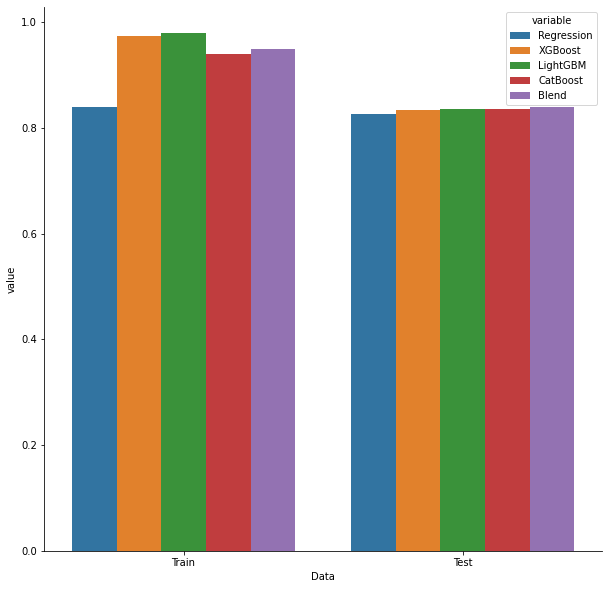

In [251]:
from matplotlib import pyplot as plt
predict = lambda clf, data: [accuracy_score(clf(x), y) for x, y in data]
data = [(X_train, y_train), (X_test, y_test)]
results = pd.DataFrame({
    "Data": ["Train", "Test"],
    "Regression": predict(reg.predict, data),
    "XGBoost": predict(xgb_clf.predict, data),
    "LightGBM": predict(lambda x: lclf.predict(x).argmax(axis=1), data),
    "CatBoost": predict(cat_clf.predict, data),
    "Blend": predict(lambda x: blend(x, classifiers).argmax(axis=1), data),
})
plottable = results.melt(id_vars='Data')
plottable

fig, ax1 = plt.subplots(figsize=(10, 10))
sns.barplot(data=plottable, x="Data", hue="variable", y="value", ax=ax1)
sns.despine(fig)